# LTSM for stonk prices
## setup imports


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, LSTM

import datetime as dt

import plotly
import chart_studio.plotly as py
import plotly.tools as tls
import plotly.express as px


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Utils

In [3]:
def list_to_np_array(tmp_list, label=""):
    result = np.array(tmp_list)
    result = np.reshape(result, (result.shape[0], result.shape[1], 1))
    print(f"{label}: row: {result.shape[0]} col: {result.shape[1]}")
    return result

### constants

In [4]:
CLOSE = 'Close'
ROW_AXIS = 0
COL_AXIS = 1

## Load Data


In [5]:
company = 'AAPL'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)
# end = dt.datetime.now() - dt.timedelta(days=1)

train_data = web.DataReader(company, 'yahoo', start, end)
train_close_data = train_data[CLOSE]

# train_data_close = train_data[CLOSE].values.reshape(-1,1)


## Prepare Data

In [6]:
# scale date to fit between 0 -> 1 could try out 0.75 and see how that works
scalar = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scalar.fit_transform(train_close_data.values.reshape(-1,1))
print(f"scaled_train_data.shape: {scaled_train_data.shape}")

# how many days to look into past
# window of data to use for pridiction
# larger window is less sensative to recent stock prices
# smaller window is more sensitive to recent stock prices
prediction_days = 30

size_data = len(scaled_train_data)

# x_train is a sliding window of 60 days of data
x_train = []

# y_train is the closing day value of stocks on 60th day
y_train = []

for x in range(prediction_days, size_data):
    prev_x = x - prediction_days
    x_training_data = scaled_train_data[prev_x:x, 0]
    # x_training_data shape = (60,)
    x_train.append(x_training_data)

    y_training_data = scaled_train_data[x, 0]
    # y_training_data shape = ()
    y_train.append(y_training_data)

x_train = list_to_np_array(x_train, "x_train")
y_train = np.array(y_train)


scaled_train_data.shape: (2012, 1)
x_train: row: 1982 col: 30


## Build model

In [22]:
model = Sequential()
# you can tweak this parameter
units = 50
# x_train.shape[1] = 30
model.add(LSTM(units=units, return_sequences= True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=units, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units=units))
model.add(Dropout(0.2))

model.add(Dense(units=1)) # predict the closing price

model.compile(optimizer="adam", loss="mean_absolute_error", metrics=[RootMeanSquaredError()])
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, shuffle=False)


Epoch 1/25
56/56 [==============================] - 7s 52ms/step - loss: 0.0750 - root_mean_squared_error: 0.0838 - val_loss: 0.1227 - val_root_mean_squared_error: 0.1421
Epoch 2/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0786 - root_mean_squared_error: 0.0883 - val_loss: 0.0715 - val_root_mean_squared_error: 0.0903
Epoch 3/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0700 - root_mean_squared_error: 0.0782 - val_loss: 0.1168 - val_root_mean_squared_error: 0.1367
Epoch 4/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0732 - root_mean_squared_error: 0.0833 - val_loss: 0.0717 - val_root_mean_squared_error: 0.0947
Epoch 5/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0719 - root_mean_squared_error: 0.0816 - val_loss: 0.1059 - val_root_mean_squared_error: 0.1295
Epoch 6/25
56/56 [==============================] - 2s 30ms/step - loss: 0.0714 - root_mean_squared_error: 0.0801 - val_loss: 0.0884 - val_root_m

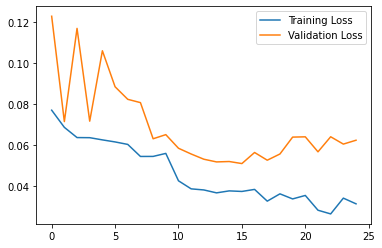

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

## Load test data

In [17]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now() - dt.timedelta(days=1)

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
y_test = test_data[CLOSE].values
print(f"train_data[CLOSE].shape: {train_data[CLOSE].shape}")
print(f"test_data[CLOSE].shape: {test_data[CLOSE].shape}")

total_dataset = pd.concat((train_data[CLOSE], test_data[CLOSE]), axis=ROW_AXIS)
print("total_dataset.shape", total_dataset.shape, type(total_dataset))
start_index = len(total_dataset) - len(test_data) - prediction_days
print(f"start_index: {start_index}")

# model_inputs is a list
model_inputs = total_dataset[start_index:].values
model_inputs_date = total_dataset[start_index:].index
# print("total_dataset[start_index:].values", model_inputs.shape, model_inputs[:-1])

# model_inputs is a column
model_inputs = model_inputs.reshape(-1,1)
# print("model_inputs.reshape(-1,1)", model_inputs.shape, model_inputs[:-1])

# model_input is a column of scaled values
model_inputs = scalar.transform(model_inputs)
# print("scalar.transform(model_inputs)", model_inputs.shape, model_inputs[:-1])

train_data[CLOSE].shape: (2012,)
test_data[CLOSE].shape: (312,)
total_dataset.shape (2324,) <class 'pandas.core.series.Series'>
start_index: 1982


## Make predictions on test data

In [18]:
x_test = []
x_test_date = []
# show the previous 30 days shown as input on the plot
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    x_test_date.append(model_inputs_date[x])

x_test = list_to_np_array(x_test, "x_test")

predicted_prices = model.predict(x_test)
# reverse the scaling
predicted_prices = scalar.inverse_transform(predicted_prices)


x_test: row: 312 col: 30


## Plot test predictions

In [19]:
import plotly.graph_objects as go
predicted_prices_length = predicted_prices.size
fig = go.Figure()
x_range = np.linspace(0, predicted_prices_length, predicted_prices_length)

fig.add_trace(go.Scatter(name="predicted", x=x_test_date, y=predicted_prices.reshape(predicted_prices_length)))
fig.add_trace(go.Scatter(name="actual", x=x_test_date, y=y_test.reshape(predicted_prices_length)))
fig.update_layout(title=f"{company} LSTM", xaxis_title="time", yaxis_title=f"{company} price")
fig.show()

## Predict next day

In [20]:
row_selection = len(model_inputs) - prediction_days
col_selection = len(model_inputs + 1)
real_data = [model_inputs[row_selection: col_selection, 0]]
real_data = list_to_np_array(real_data, "real_data")

prediction = model.predict(real_data)
prediction = scalar.inverse_transform(prediction)[0][0]
prediction_str = "{:0.2f}".format(prediction)
test_end_str = test_end.strftime("%m-%d-%Y")
print(f"Prediction for {test_end_str}: ${prediction_str}")

real_data: row: 1 col: 30
Prediction for 03-29-2021: $103.12


## RMSE: how good is it

In [21]:
se = np.square(y_test - predicted_prices)
mse = np.mean(se)
rmse = np.sqrt(mse)
rmse_str = "{:0.2f}".format(rmse)
print(f'RMSE: {rmse_str}')

RMSE: 31.59
